In [374]:
# Computer vision to detect object and angle of rotation with data gotten from 
#https://www.kaggle.com/jessicali9530/coil100

## Transfer learning

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
import cv2
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet, resnet50
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from keras.applications.mobilenet import decode_predictions
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.optimizers import Adam
import argparse
import random

Using TensorFlow backend.


In [95]:
resnet = resnet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

80142336/80134624 [==============================] - 36s 0us/step


In [3]:
#Data collection creation
def get_data(folder, name,train_ind,valid_ind, test_ind):
    for file in os.listdir(folder):       
        if file==name:
#             l=len(os.listdir(folder+'/'+file))
            t='train'
#             tangle=[]
            v='valid'
#             vangle=[]
            tt='test'
#             ttangle=[]
            if t not in os.listdir(folder):
                os.mkdir(folder+'/'+t)
            if v not in os.listdir(folder):
                os.mkdir(folder+'/'+v)
            if tt not in os.listdir(folder):
                os.mkdir(folder+'/'+tt)
            for pic in os.listdir(folder+'/'+name):
                if int(pic.split('__')[1].split('.')[0]) in train_ind and pic[:3]=='obj':
#                     if name not in os.listdir(folder+'/'+t):
#                         os.mkdir(folder+'/'+t+'/'+name)
                    if pic not in os.listdir(folder+'/'+t):
                        shutil.copy(folder+'/'+file+'/'+pic,folder+'/'+t)
                        tangle.append(int(pic.split('__')[1].split('.')[0]))
                if int(pic.split('__')[1].split('.')[0]) in valid_ind and pic[:3]=='obj':
#                     if name not in os.listdir(folder+'/'+v):
#                         os.mkdir(folder+'/'+v+'/'+name)
                    if pic not in os.listdir(folder+'/'+v):
                        shutil.copy(folder+'/'+file+'/'+pic,folder+'/'+v)
                        vangle.append(int(pic.split('__')[1].split('.')[0]))
                if int(pic.split('__')[1].split('.')[0]) in test_ind and pic[:3]=='obj':
#                     if name not in os.listdir(folder+'/'+tt):
#                         os.mkdir(folder+'/'+tt+'/'+name)
                    if pic not in os.listdir(folder+'/'+tt):
                        shutil.copy(folder+'/'+file+'/'+pic,folder+'/'+tt)
                        ttangle.append(int(pic.split('__')[1].split('.')[0]))
                     
    return

In [9]:
def group_data(folder):
    for obj in os.listdir(folder):
        if obj[-3:]=='png':
            if obj.split('_')[0] not in os.listdir(folder):
                os.mkdir(folder+'/'+obj.split('_')[0])
                shutil.move(folder+'/'+obj,folder+'/'+obj.split('_')[0])
            else:
                shutil.move(folder+'/'+obj,folder+'/'+obj.split('_')[0])
        else:
            os.remove(folder+'/'+obj)
    return

def modify_pic(folder):
    for file in os.listdir(folder):
        first=folder+f'/{file}/{file}__0.png'
        pic1=np.asarray(Image.open(first))
        area=(0,0,pic1.shape[0],pic1.shape[1])
        
        for fil in os.listdir(folder+'/'+file):
            pict=np.round((np.asarray(Image.open(folder+'/'+file+'/'+fil).crop(area))*3+pic1)/4,0)
            pict=pict.astype(np.uint8)
            pict=Image.fromarray(pict)
            pict.save(folder+'/'+file+'/'+fil)
    return

In [5]:
shutil.unpack_archive('C:/Users/My PC/Documents/Computer vision/coil100.zip','C:/Users/My PC/Documents/Computer vision')

In [10]:
folder='C:/Users/My PC/Documents/Computer vision/coil-100/coil-100'
#group_data(folder)
modify_pic(folder)
tangle=[]
vangle=[]
ttangle=[]
for name in os.listdir(folder):
    sep=[i for i in range(0,360,5)]
    sep1=random.sample(sep, 50)
    sep2=random.sample(list(set(sep)-set(sep1)),12)
    sep3=list(set(sep)-set(sep1).union(set(sep2)))
    get_data(folder,name,sep1,sep2,sep3)        

In [11]:
train_dir = f'{folder}/train'
validation_dir = f'{folder}/valid'

nTrain = len(train_dir)
nVal = len(validation_dir)
trainY=os.listdir(train_dir)
validY=os.listdir(validation_dir)

In [270]:
class id_angle:

    def id_branch(inputs, numCategories,
        finalAct="softmax", chanDim=-1):
        # utilize a lambda layer to convert the 3 channel input to a
        # grayscale representation
        x = inputs#Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
                # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        # define a branch of output layers for the number of different
        # clothing categories (i.e., shirts, jeans, dresses, etc.)
        x = Flatten()(x)
        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numCategories)(x)
        x = Activation(finalAct, name="id_output")(x)

        # return the category prediction sub-network
        return x
    #     @staticmethod
    def angle_branch(inputs, finalAct="tanh",
        chanDim=-1):
        # CONV => RELU => POOL
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("tanh")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.025)(x)
        x = Dense(72)(x)# CONV => RELU => POOL 
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Dense(40)(x)# CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.5)(x)
        # define a branch of output layers for the number of different
        # colors (i.e., red, black, blue, etc.)
        x = Flatten()(x)
        x = Dense(20)(x)
        x = Activation("selu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="angle_output")(x)

        # return the angle prediction sub-network
        return x
    #     @staticmethod
    def build(width, height, numCategories,
        finalAct1="softmax", finalAct2='linear'):
        # initialize the input shape and channel dimension (this code
        # assumes you are using TensorFlow which utilizes channels
        # last ordering)
        inputShape = (height, width,64)
        chanDim = -1

        # construct both the "category" and "color" sub-networks
        inputs = Input(shape=inputShape)
        idBranch = id_angle.id_branch(inputs,
            numCategories, finalAct=finalAct1, chanDim=chanDim)
        angleBranch = id_angle.angle_branch(inputs,
            finalAct=finalAct2, chanDim=chanDim)

        # create the model using our input (the batch of images) and
        # two separate outputs -- one for the clothing category
        # branch and another for the color branch, respectively
        model = Model(
            inputs=inputs,
            outputs=[idBranch, angleBranch],
            name="idangle")

        # return the constructed network architecture
        return model

In [175]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 5
INIT_LR = 1e-3
BS = 32
batch_size=BS
IMAGE_DIMS = (224, 224, 3)

In [365]:
def read_data(path):
    data=[]
    id_cat=[]
    for imagePath in os.listdir(path):
        # load the image, pre-process it, and store it in the data list
        image = Image.open(path+'/'+imagePath)
        image = image.resize((IMAGE_DIMS[1], IMAGE_DIMS[0]))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.asarray(image)
        data.append(image)

        # extract the clothing color and category from the path and
        # update the respective lists
        id_cat.append(imagePath.split('__')[0])
    return data, id_cat

def test_accuracy(model,testdata,testY, ttangle):
    preds=model.predict(testdata, batch_size=32)
    object_id=np.array([trainYLB.classes_[x.argmax()] for x in preds[0]])
    angles=np.array([x*355 for x in preds[1].flatten()])
    acc=sum([object_id[i]==testY[i] for i in range(len(testY))])/len(testY)
    mse=sum([((angles[i]-ttangle[i])**2)/len(testY) for i in range(len(testY))])
    return acc, mse

In [131]:
train_data, trainY=read_data(train_dir)
valid_data, validY=read_data(validation_dir)
train_data=np.array(train_data)
valid_data=np.array(valid_data)
tangle=np.array(tangle)
tangle=tangle.astype(np.float)
vangle=np.array(vangle)
vangle=vangle.astype(np.float)

In [161]:
# convert the label lists to NumPy arrays prior to binarization
trainY = np.array(trainY)
validY = np.array(validY)
 
# binarize both sets of labels
trainYLB = LabelBinarizer()
validYLB = LabelBinarizer()
trainY = trainYLB.fit_transform(trainY)
validY = validYLB.fit_transform(validY)

In [346]:
# initialize our FashionNet multi-output network
model = id_angle.build(28, 28,
	numCategories=len(trainYLB.classes_),
	finalAct1="softmax", finalAct2='linear')
 
# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
	"id_output": "categorical_crossentropy",
	"angle_output": "mse",
}
lossWeights = {"id_output": 1.0, "angle_output": 5}
 
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=2*INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
	metrics=["acc"])

[INFO] compiling model...


In [132]:
trainX=np.array([mobilenet.predict(np.expand_dims(x,axis=0)) for x in train_data])
validX=np.array([mobilenet.predict(np.expand_dims(x,axis=0)) for x in valid_data])

In [347]:
trainX=trainX.reshape((len(trainX),28,28,64))
validX=validX.reshape((len(validX),28,28,64))
# train the network to perform multi-output classification
H = model.fit(trainX,
	{"id_output": trainY, "angle_output": tangle/355},
	validation_data=(validX,
		{"id_output": validY, "angle_output": vangle/355}),
	epochs=EPOCHS, batch_size=BS,
	verbose=1)
 
# save the model to disk
print("[INFO] serializing network...")
model.save(f"{folder}/model")

Train on 5000 samples, validate on 1200 samples
Epoch 1/5
5000/5000 [==============================] - 124s 25ms/step - loss: 8.5519 - id_output_loss: 4.7067 - angle_output_loss: 0.7690 - id_output_acc: 0.0474 - angle_output_acc: 0.0138 - val_loss: 5.3163 - val_id_output_loss: 3.6026 - val_angle_output_loss: 0.3427 - val_id_output_acc: 0.1392 - val_angle_output_acc: 0.0125
Epoch 2/5
5000/5000 [==============================] - 92s 18ms/step - loss: 5.1448 - id_output_loss: 3.1359 - angle_output_loss: 0.4018 - id_output_acc: 0.2024 - angle_output_acc: 0.0132 - val_loss: 3.8754 - val_id_output_loss: 2.1617 - val_angle_output_loss: 0.3427 - val_id_output_acc: 0.4075 - val_angle_output_acc: 0.0125
Epoch 3/5
5000/5000 [==============================] - 89s 18ms/step - loss: 3.7832 - id_output_loss: 2.0819 - angle_output_loss: 0.3403 - id_output_acc: 0.4224 - angle_output_acc: 0.0146 - val_loss: 3.2809 - val_id_output_loss: 1.5672 - val_angle_output_loss: 0.3427 - val_id_output_acc: 0.5308 -

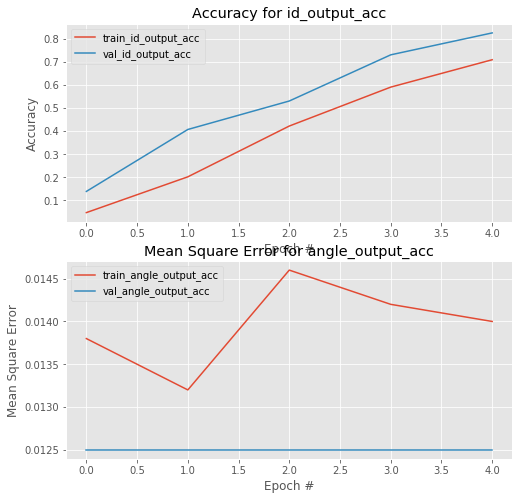

<Figure size 864x1440 with 0 Axes>

In [373]:
# create a new figure for the accuracies
accuracyNames = ["id_output_acc", "angle_output_acc"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))
titles=['Accuracy', 'Mean Square Error']
# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
    # plot the loss for both the training and validation data
    ax[i].set_title(f"{titles[i]} for {l}")
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel(titles[i])
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label='train_'+l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()

plt.figure(figsize=(12,20))
plt.show()
# save the accuracies figure
plt.tight_layout()
plt.savefig(f"{folder}/_accs.png")
plt.close()

In [366]:
model.predict(folder+'/test/obj1__130.png')
test_data, testY=read_data(folder+'/test')
test_data=np.array(test_data)   
testdata=np.array([x.reshape((28,28,64)) for x in mobilenet.predict(test_data,batch_size=32)]) 
acc,mse=test_accuracy(model, testdata,testY,ttangle)
print(f"Test Object Identification Accuracy:{acc}")
print(f"Test Angle MSE:{mse}")

Test Object Identification Accuracy:0.806
Test Angle MSE:39051.174999999996


## Training from Scratch

In [ ]:
#Data collection creation
def get_data(folder, name,train_ind,valid_ind, test_ind):
    for file in os.listdir(folder):       
        if file==name:
            t='train'
            v='valid'
            tt='test'
            if t not in os.listdir(folder):
                os.mkdir(folder+'/'+t)
            if v not in os.listdir(folder):
                os.mkdir(folder+'/'+v)
            if tt not in os.listdir(folder):
                os.mkdir(folder+'/'+tt)
            for pic in os.listdir(folder+'/'+name):
                if int(pic.split('__')[1].split('.')[0]) in train_ind and pic[:3]=='obj':
                    if pic not in os.listdir(folder+'/'+t):
                        shutil.copy(folder+'/'+file+'/'+pic,folder+'/'+t)
                        tangle.append(int(pic.split('__')[1].split('.')[0]))
                if int(pic.split('__')[1].split('.')[0]) in valid_ind and pic[:3]=='obj':
                    if pic not in os.listdir(folder+'/'+v):
                        shutil.copy(folder+'/'+file+'/'+pic,folder+'/'+v)
                        vangle.append(int(pic.split('__')[1].split('.')[0]))
                if int(pic.split('__')[1].split('.')[0]) in test_ind and pic[:3]=='obj':
                    if pic not in os.listdir(folder+'/'+tt):
                        shutil.copy(folder+'/'+file+'/'+pic,folder+'/'+tt)
                        ttangle.append(int(pic.split('__')[1].split('.')[0]))
                     
    return
#this function puts each object in one folder
def group_data(folder):
    for obj in os.listdir(folder):
        if obj[-3:]=='png':
            if obj.split('_')[0] not in os.listdir(folder):
                os.mkdir(folder+'/'+obj.split('_')[0])
                shutil.move(folder+'/'+obj,folder+'/'+obj.split('_')[0])
            else:
                shutil.move(folder+'/'+obj,folder+'/'+obj.split('_')[0])
        else:
            os.remove(folder+'/'+obj)
    return

#this is my data preparation function: to compare rotation I added the angle zero object to all the objects
#this will be done iteratively after grouping the data with the above function
def modify_pic(folder):
    for file in os.listdir(folder):
        first=folder+f'/{file}/{file}__0.png'
        pic1=np.asarray(Image.open(first))
        area=(0,0,pic1.shape[0],pic1.shape[1])
        
        for fil in os.listdir(folder+'/'+file):
            pict=np.round((np.asarray(Image.open(folder+'/'+file+'/'+fil).crop(area))*3+pic1)/4,0)
            pict=pict.astype(np.uint8)
            pict=Image.fromarray(pict)
            pict.save(folder+'/'+file+'/'+fil)
    return

def read_data(path):
    data=[]
    id_cat=[]
    for imagePath in os.listdir(path):
        # load the image, pre-process it, and store it in the data list
        image = Image.open(path+'/'+imagePath)
        image = image.resize((IMAGE_DIMS[1], IMAGE_DIMS[0]))
        image = np.asarray(image)
        data.append(image)

        # extract the object id from the path and
        # update the list
        id_cat.append(imagePath.split('__')[0])
    return data, id_cat

def test_accuracy(model,testdata,testY, ttangle):
    preds=model.predict(testdata, batch_size=32)
    object_id=np.array([trainYLB.classes_[x.argmax()] for x in preds[0]])
    angles=np.array([x*355 for x in preds[1].flatten()])
    acc=sum([object_id[i]==testY[i] for i in range(len(testY))])/len(testY)
    mse=sum([((angles[i]-ttangle[i])**2)/len(testY) for i in range(len(testY))])
    return acc, mse

class id_angle:
    def id_branch(inputs, numCategories,
        finalAct="softmax", chanDim=-1):
        # utilize a lambda layer to convert the 3 channel input to a
        # grayscale representation
        Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)
        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(numCategories)(x)
        x = Activation(finalAct, name="id_output")(x)

        # return the category prediction sub-network
        return x

    def angle_branch(inputs, finalAct="linear",
        chanDim=-1):
        # CONV => RELU => POOL
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("tanh")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.025)(x)
        x = Dense(72)(x)
        # CONV => RELU => POOL 
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Dense(40)(x)
        #CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.5)(x)

        x = Flatten()(x)
        x = Dense(20)(x)
        x = Activation("selu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="angle_output")(x)

        # return the angle prediction sub-network
        return x
    #     @staticmethod
    def build(width, height, numCategories,
        finalAct1="softmax", finalAct2='linear'):
        # initialize the input shape and channel dimension (this code
        # assumes you are using TensorFlow which utilizes channels
        # last ordering)
        inputShape = (height, width,64)
        chanDim = -1

        # construct both the "object id" and "angle" sub-networks
        inputs = Input(shape=inputShape)
        idBranch = id_angle.id_branch(inputs,
            numCategories, finalAct=finalAct1, chanDim=chanDim)
        angleBranch = id_angle.angle_branch(inputs,
            finalAct=finalAct2, chanDim=chanDim)

        # create the model using our input (the batch of images) and
        # two separate outputs -- one for the id category
        # branch and another for the angle branch, respectively
        model = Model(
            inputs=inputs,
            outputs=[idBranch, angleBranch],
            name="idangle")

        # return the constructed network architecture
        return model

In [ ]:
shutil.unpack_archive('.../Computer vision/coil100.zip','.../Computer vision') #unzip the file

In [ ]:
folder='.../Computer vision/coil-100/coil-100'
group_data(folder)
modify_pic(folder)
tangle=[]#train angle
vangle=[]#validation angle
ttangle=[]#test angle
for name in os.listdir(folder):#we shuffle our data here
    sep=[i for i in range(0,360,5)]
    sep1=random.sample(sep, 50)
    sep2=random.sample(list(set(sep)-set(sep1)),12)
    sep3=list(set(sep)-set(sep1).union(set(sep2)))
    get_data(folder,name,sep1,sep2,sep3)   

In [ ]:
train_dir = f'{folder}/train'
validation_dir = f'{folder}/valid'

trainY=os.listdir(train_dir)
validY=os.listdir(validation_dir)

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 5
INIT_LR = 1e-3
BS = 32
batch_size=BS
IMAGE_DIMS = (224, 224, 3)

In [ ]:
#Obtain the data sets for training, validation and testing
train_data, trainY=read_data(train_dir)
valid_data, validY=read_data(validation_dir)
train_data=np.array(train_data)
valid_data=np.array(valid_data)
tangle=np.array(tangle)
tangle=tangle.astype(np.float)
vangle=np.array(vangle)
vangle=vangle.astype(np.float)

In [ ]:
# convert the label lists to NumPy arrays prior to binarization
trainY = np.array(trainY)
validY = np.array(validY)
 
# binarize both sets of labels
trainYLB = LabelBinarizer()
validYLB = LabelBinarizer()
trainY = trainYLB.fit_transform(trainY)
validY = validYLB.fit_transform(validY)

In [ ]:
# initialize our idangle multi-output network
model = id_angle.build(28, 28,
    numCategories=len(trainYLB.classes_),
    finalAct1="softmax", finalAct2='linear')
 
# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
losses = {
	"id_output": "categorical_crossentropy",
	"angle_output": "mse",
}
lossWeights = {"id_output": 1.0, "angle_output": 5}
 
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=2*INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
    metrics=["acc"])

In [ ]:
# train the network to perform multi-output classification and regression
H = model.fit(train_data,
    {"id_output": trainY, "angle_output": tangle/355},
    validation_data=(valid_data,
        {"id_output": validY, "angle_output": vangle/355}),
    epochs=EPOCHS, batch_size=BS,
    verbose=1)
 
# save the model to disk
print("[INFO] serializing network...")
model.save(f"{folder}/model")

In [ ]:
# create a new figure for the accuracies
accuracyNames = ["id_output_acc", "angle_output_acc"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))
titles=['Accuracy', 'Mean Square Error']
# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
    # plot the loss for both the training and validation data
    ax[i].set_title(f"{titles[i]} for {l}")
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel(titles[i])
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label='train_'+l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()

plt.figure(figsize=(12,20))
plt.show()
# save the accuracies figure
plt.tight_layout()
plt.savefig(f"{folder}/_accs.png")
plt.close()

In [ ]:
test_data, testY=read_data(folder+'/test')
test_data=np.array(test_data)  
acc,mse=test_accuracy(model,test_data,testY,ttangle)
print(f"Test Object Identification Accuracy:{acc}")
print(f"Test Angle MSE:{mse}")